# Analysing USA Consumer Price Index 

Consumer Price Index for All Urban Consumers (CPI-U) is a common indicator of inflation and rose 0.1 percent in March on a seasonally
adjusted basis, after increasing 0.4 percent in February, the U.S. Bureau of Labor Statistics [reported] (https://www.bls.gov/news.release/cpi.nr0.htm)
today. Over the last 12 months, the all items index increased 5.0 percent before seasonal adjustment.

The all items index increased 5.0 percent for the 12 months ending March; this was the smallest 12-month
increase since the period ending May 2021. The all items less food and energy index rose 5.6 percent
over the last 12 months. The energy index decreased 6.4 percent for the 12 months ending March, and the
food index increased 8.5 percent over the last year.

In this project we access, parse, visualize and analyze the data from the U.S. Bureau of Labor Statistics, and use it to predict the inflation rate uing 
[ARIMA]() and [Prophet] ().


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Wrangling and Data Source Libraries
import os
import json
import requests

# Viz and EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime


# Stats Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

# Metrics
from sklearn.metrics import mean_squared_error


# Arch
from arch import arch_model

# Prophet
from prophet import Prophet

# Getting or Refreshing the Data
Using json from the [BLC Public API](https://beta.bls.gov/dataQuery/find?fq=survey:[cu]&s=popularity:D)
Consumer Price Index for All Urban Consumers (CPI-U)
- CUUR0000SA0 unadjusted
- CUSR0000SA0 seasonaly adjusted

The monthly release dates for the CPI are indicated (here)[https://www.bls.gov/schedule/news_release/cpi.htm].

Since the data for each month is released before the 15th of the following month, we will use the 15th as he trigger date for updates. 

In [2]:
# Finding the current month to see if we have uptodate data.
currentDay = datetime.now().day
currentMonth = datetime.now().month
currentYear = datetime.now().year
currentDay, currentMonth, currentYear

(9, 5, 2023)

In [3]:
def get_json_data(currentYear):
    """
    Function ussing the API to get the jason data up to the current uear when called. Returns a json file
    """

    headers = {'Content-type': 'application/json'}
    
    all_json_data = []
    step = 20 #in years
    for year in range (1980,currentYear+1,step):
        parameters = json.dumps({"registrationkey":"YOUR_Reg_Key_Here", "seriesid":['CUSR0000SA0'], "startyear":str(year), "endyear":str(year+step), "calculations":"true"})
        response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data = parameters, headers = headers)

        json_data = json.loads(response.text)
        all_json_data.append(json_data)

    with open ('data/all_json_data.json','w') as outfile:
        json.dump(all_json_data, outfile)
    return all_json_data

In [4]:
def parse_json(file):
    """
        Function to loop through and parse the outpot json from the BLS website
    """    
    data_dict =dict()
    for section in file:
        for part in section['Results']['series']:
            for item in part['data']:
                year = item['year']
                month = item['periodName']
                value = item['value']
                data_dict[month+' '+ year] = value
    df = pd.DataFrame(data_dict.items(),columns = ['date','CPI'])
    df['CPI'] = df['CPI'].astype(float)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

In [5]:
path = 'data/all_json_data.json'
if os.path.isfile(path):
    # if the file exists
    with open (path,'r') as openfile:
        all_json_data = json.load(openfile)
    df = parse_json(all_json_data)

    if (currentMonth - df.index[-1].month == 2) & (currentDay>=15): #refresh data if new daya is available based on schedule.
        all_json_data = get_json_data(currentYear)
        df = parse_json(all_json_data)
    else:
        pass
else:
    all_json_data = get_json_data(currentYear)
    df = parse_json(all_json_data)

We pick the data from 1983 onwards, as it was the year the inflation rate was re-calibrated by the Federal Reserve.  

In [6]:
df = df[df.index>'01/12/1983'].copy()

# Data Exploration
### Decomposing the data to check seasonality, ternds and residuals. 

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as [follows](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/):

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

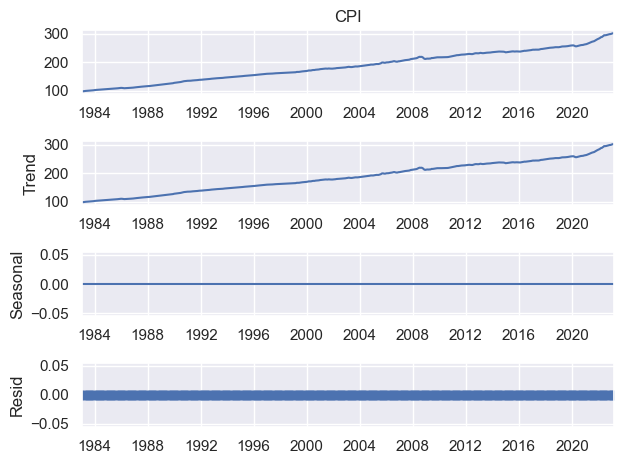

In [7]:
sns.set()
result = seasonal_decompose(df['CPI'], model='additive', period=1)
x = result.plot()

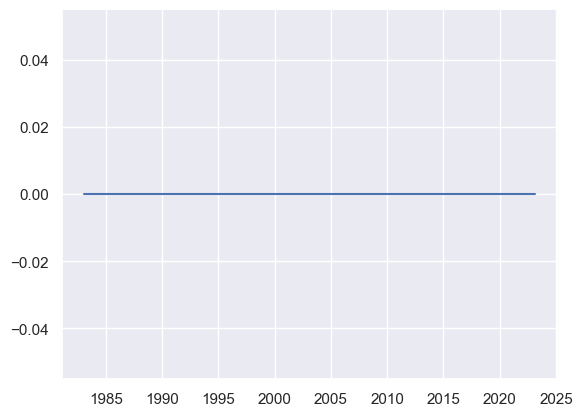

In [8]:
plt.plot(result.resid)

# Visualise and explore the data
Create Plotly figure of data with slider and a figure with percentage change based on values a year ago. 

In [9]:
def plotly_plot (df, x , y, title, width, height): # Plotly plotting function for time series
    
    # Create figure
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=list(x), y=list(y)))

    # Set title
    fig.update_layout(
        title_text=title,
        width=width,
        height=height
    )

    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=6,
                        label="6m",
                        step="month",
                        stepmode="backward"),
                    dict(count=1,
                        label="YTD",
                        step="year",
                        stepmode="todate"),
                    dict(count=1,
                        label="1y",
                        step="year",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show()

In [10]:
plotly_plot(df,df.index, df.CPI, 'Raw Consumer Price Index', 1000, 500)

In [11]:
# Plot percentage
df['pct-change'] =df.CPI.pct_change(periods=12)*100
plotly_plot(df,df.index, df['pct-change'], 'Consumer Price Index Percentage Chnage', 1000, 500)

## Visualising the year-on-year percentage chage 

In [84]:
plot_df = df[df.index>='01/01/2000']


plot_df['date'] = plot_df.index
plot_df['month'] = plot_df['date'].apply(lambda x: x.month)
plot_df['year'] = plot_df['date'].apply(lambda x: x.year)

fig = px.box(plot_df, x="month", y="pct-change",
            hover_data='year',
            points = 'all',
            labels = {'pct-change':'CPI Percentage Change', 'month':'Month'})
fig.update_layout(
    xaxis = dict(tickmode = 'linear'),
        title_text="YoY CPI Percentage Change from 2000")

<Axes: xlabel='pct-change', ylabel='date'>

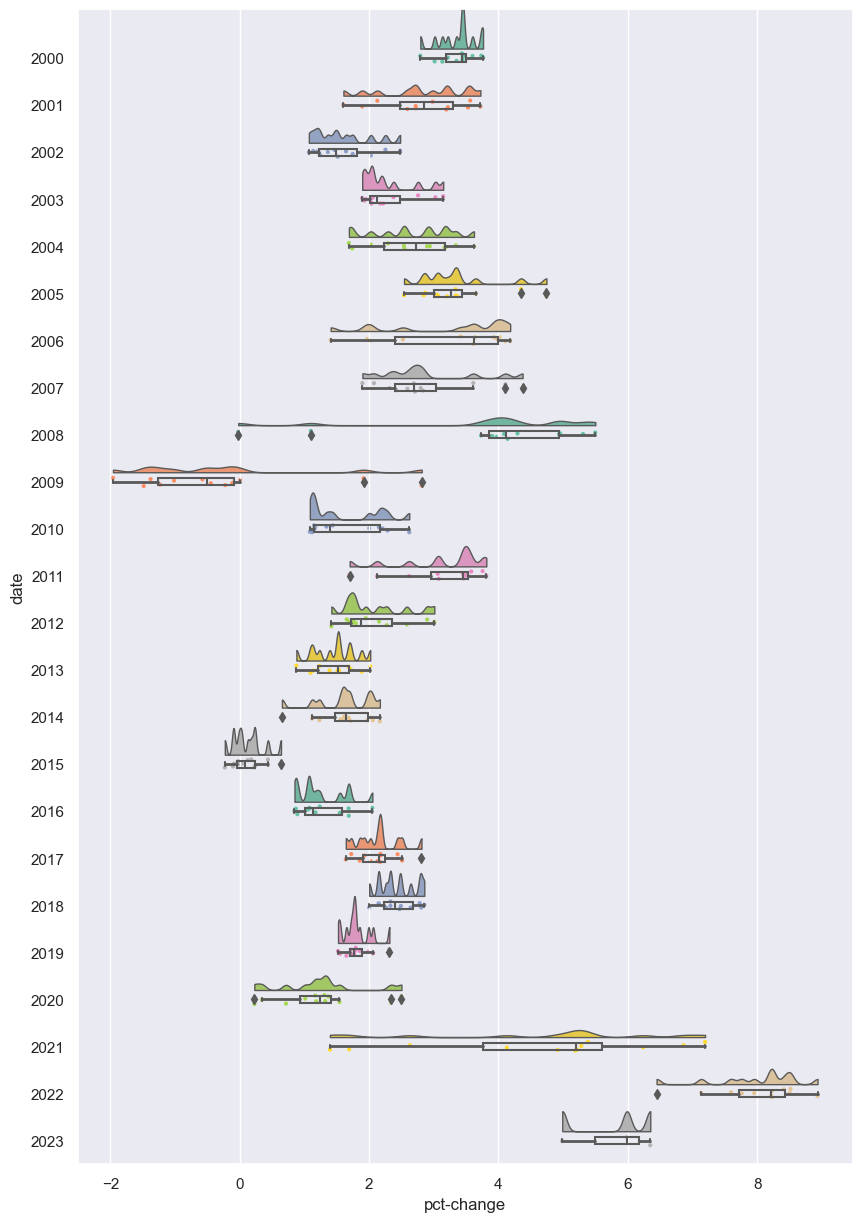

In [92]:
import ptitprince as pt
fig, ax = plt.subplots(figsize=(10, 15))
sns.set_style("darkgrid")
pt.RainCloud(x = plot_df.index.year, y = plot_df['pct-change'], data = plot_df, palette = "Set2", bw = .09,
                 width_viol = 2, ax = ax, orient = 'h')


In [14]:
plot_df

,CPI,pct-change,date,month
date,,,,
2000-01-01,169.300,2.792957,2000-01-01,1
2000-02-01,170.000,3.217972,2000-02-01,2
2000-03-01,171.000,3.762136,2000-03-01,3
2000-04-01,170.900,3.013864,2000-04-01,4
2000-05-01,171.200,3.132530,2000-05-01,5
...,...,...,...,...
2022-11-01,298.598,7.135348,2022-11-01,11
2022-12-01,298.990,6.444940,2022-12-01,12
2023-01-01,300.536,6.347156,2023-01-01,1


# Stationarity

We test the stationarity with a rolling mean and std, Augmented Dicky Fuller and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests. 

For the tests, the null hypothesis is that a unit root is present in the time series data. The alternative hypothesis is trend stationarity.

## Data Trends, Rolling Mean, Standard Deviation, Detrending Methods

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

### ADF test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

### KPSS test
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

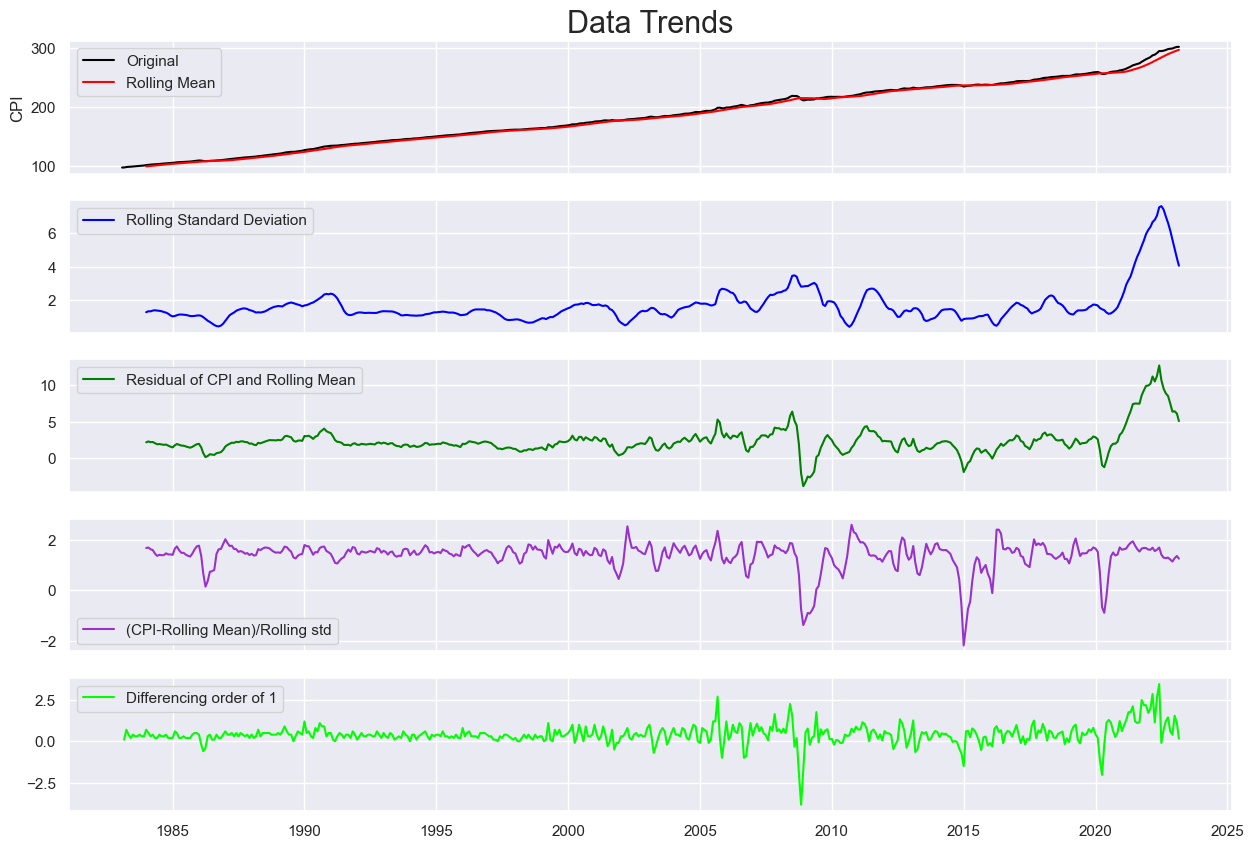

In [15]:
numfig = 5

rmean=df['CPI'].rolling(window=12).mean()
rstd=df['CPI'].rolling(window=12).std()
#print(rmean,rstd)

# First order differencing
diff = df['CPI']-df['CPI'].shift(1)
diff = diff.dropna()
detrend = pd.DataFrame(diff, index = diff.index)


fig, ax = plt.subplots(numfig,1, sharex = True, figsize = (15,10))
ax[0].plot(df['CPI'] , color='black',label='Original')
ax[0].plot(rmean , color='red',label='Rolling Mean')
ax[0].set_ylabel('CPI')

ax[1].plot(rstd,color='blue',label = 'Rolling Standard Deviation')

ax[2].plot(df['CPI']-rmean , color='green',label='Residual of CPI and Rolling Mean')

ax[3].plot((df['CPI']-rmean)/rstd , color='darkorchid',label='(CPI-Rolling Mean)/Rolling std')

ax[4].plot(diff , color='lime', label='Differencing order of 1')


for i in range(0,numfig):
 ax[i].legend(loc='best')


ax[0].set_title("Data Trends", fontdict = {'fontsize':22})
plt.show(block=False)

In [16]:
df.index.year

Int64Index([1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983, 1983,
            ...
            2022, 2022, 2022, 2022, 2022, 2022, 2022, 2023, 2023, 2023],
           dtype='int64', name='date', length=482)

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [17]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto") # H0: data is stationary around a trend.
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [18]:
kpss_test(df['CPI'])

Results of KPSS Test:
Test Statistic            3.788503
p-value                   0.010000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The null hypothesis of the KPSS is that the time series is stationary. We note that the p-value is 0.08 > 0.05. This indicates that we can not reject the null hypothesis with sufficient confidence. 

As can be seen, the KPSS indicates the data in non-stationary around a trend.



## Applying the Augmented Dicky-Fuller test   

In [19]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [20]:
adf_test(df['CPI'])

Results of Dickey-Fuller Test:
Test Statistic                   1.415609
p-value                          0.997184
#Lags Used                      15.000000
Number of Observations Used    466.000000
Critical Value (1%)             -3.444461
Critical Value (5%)             -2.867762
Critical Value (10%)            -2.570084
dtype: float64


The null hypothesis of the ADF is that the time series is non-stationary.
As the p-value is almost 1, we cannot reject the null hypothesis (that the data is nonstationary), so we conclude that the time series is non-stationary. This is of course evident by visual inspection too. 

Based upon the significance level of 0.05 and the p-value of KPSS test, there is not enough evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary around a trend as per the KPSS and ADF tests.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting.

## Correcting for Non-Stationarity
### Approach 1: Detrending by differencing

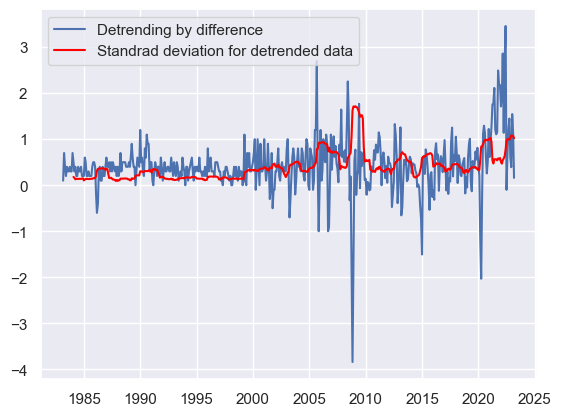

In [21]:
diff = df['CPI']-df['CPI'].shift(1)
diff = diff.dropna()
detrend = pd.DataFrame(diff, index = diff.index).rename(columns={'CPI':'Diff_ord_1'})
plt.plot(detrend, label = 'Detrending by difference')


diff_rstd = detrend.rolling(12).std()
plt.plot(diff_rstd, color = 'red', label = 'Standrad deviation for detrended data')

plt.legend()
plt.show()

### Approach 2: Detrending by subtracting the rolling mean

In [22]:
detrend['CPI-rolMean'] = (df['CPI']-rmean)
detrend.dropna(inplace=True)

## Comparing ADF and KPSS Test Results for Both Detrending Approaches

In [23]:
print('Results for differencing')
kpss_test(detrend['Diff_ord_1'])
print('\n')
print('Results for rolling mean')
kpss_test(detrend['CPI-rolMean'])

Results for differencing
Results of KPSS Test:
Test Statistic           0.498692
p-value                  0.041961
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Results for rolling mean
Results of KPSS Test:
Test Statistic            0.459258
p-value                   0.051613
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [24]:
print('Results for differencing')
adf_test(detrend['Diff_ord_1'])
print('\n')
print('Results for rolling mean')
adf_test(detrend['CPI-rolMean'])

Results for differencing
Results of Dickey-Fuller Test:
Test Statistic                  -3.151160
p-value                          0.022992
#Lags Used                      14.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


Results for rolling mean
Results of Dickey-Fuller Test:
Test Statistic                  -3.101744
p-value                          0.026424
#Lags Used                      15.000000
Number of Observations Used    455.000000
Critical Value (1%)             -3.444804
Critical Value (5%)             -2.867913
Critical Value (10%)            -2.570165
dtype: float64


We have a sufficiently small p-value to reject the null hypothesis and assume that the data is stationary. We choose the *Rolling mean Subtraction* detrending approach based on the ADF and KPSS test values. 

# Checking the Auto-Correlation and Partial Auto-Correlation Functions

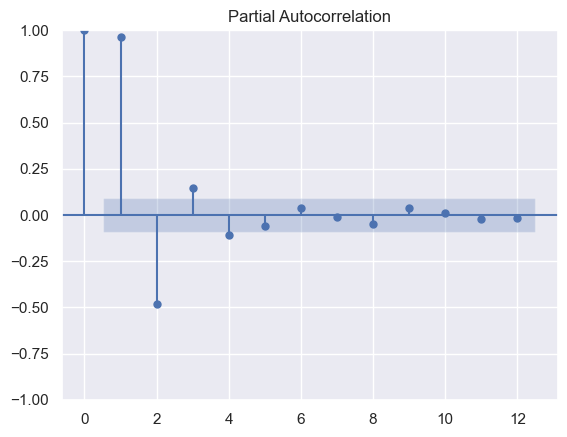

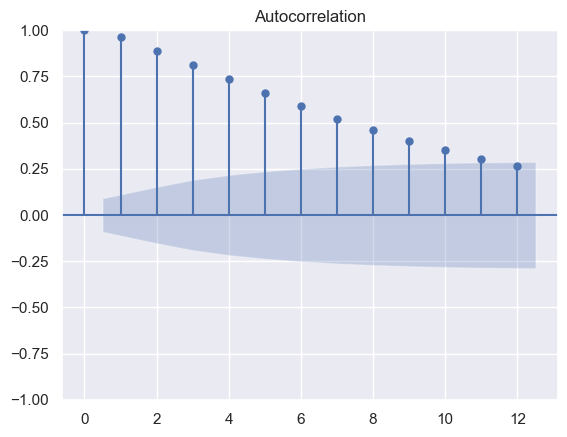

In [25]:
pacf = plot_pacf(detrend['CPI-rolMean'], lags = 12)
acf = plot_acf(detrend['CPI-rolMean'], lags = 12)
# for auto regression we use the PACF, as it only has the direct effects. 

# Aside
Does using a simple log transform make a data stationary? 

In [26]:
kpss_test(np.log(df['CPI']))

Results of KPSS Test:
Test Statistic            3.745887
p-value                   0.010000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Ramin\AppData\Local\Programs\Python\envs\time_series\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [27]:
adf_test(np.log(df['CPI']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.745148
p-value                          0.834706
#Lags Used                      15.000000
Number of Observations Used    466.000000
Critical Value (1%)             -3.444461
Critical Value (5%)             -2.867762
Critical Value (10%)            -2.570084
dtype: float64


*As can be seen form above, doing a log transformation of the CPI data does NOT make it stationary. ONly doing a difference makes it stationary.*

# Train test Split
We use one year as the testing set

Training dataset: 459, Test dataset: 12


<Axes: xlabel='date'>

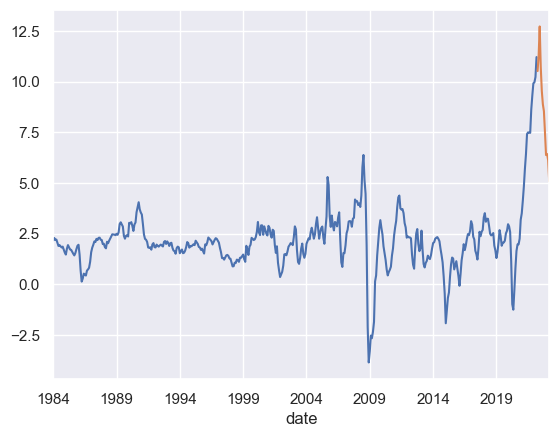

In [28]:
split_point = len(detrend['CPI-rolMean']) - 12
train, test = detrend['CPI-rolMean'][0:split_point], detrend['CPI-rolMean'][split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train.plot()
test.plot()


# Performing ARIMA on Training Data

In [29]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(train, trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=511.101, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1704.894, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=645.007, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1196.659, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2199.687, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=509.837, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=877.651, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=523.436, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=511.344, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=716.261, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=512.198, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=512.997, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=518.446, Time=0.09 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 2.143 seconds


In [30]:
from warnings import filterwarnings
filterwarnings('ignore')

arima_model = ARIMA((train), order = (1,0,2))
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            CPI-rolMean   No. Observations:                  459
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -249.919
Date:                Tue, 09 May 2023   AIC                            509.837
Time:                        09:43:38   BIC                            530.483
Sample:                    01-01-1984   HQIC                           517.968
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3982      0.474      5.061      0.000       1.469       3.327
ar.L1          0.9203      0.017     54.741      0.000       0.887       0.953
ma.L1          0.6215      0.036     17.246      0.000       0.551       0.692
ma.L2          0.2017      0.051      3.973      0.000       0.102       0.301
sigma2         0.1727      0.006     27.092      0.000       0.160       0.185
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1094.61
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               5.71   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

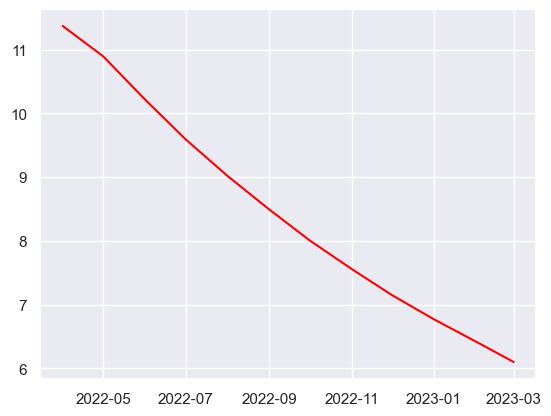

In [31]:
forecast = arima_fit.forecast(steps=12)
plt.plot(forecast, color = 'red')

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = train.index, y = train, mode = 'lines', name = 'train'))
fig.add_trace(go.Scatter(x = test.index, y = test, mode = 'lines', name = 'test'))
fig.add_trace(go.Scatter(x = forecast.index, y = forecast, mode = 'lines', name = 'forecast'))

fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=6,
                        label="6m",
                        step="month",
                        stepmode="backward"),
                    dict(count=1,
                        label="YTD",
                        step="year",
                        stepmode="todate"),
                    dict(count=1,
                        label="1y",
                        step="year",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
fig.show()

In [33]:
mse = mean_squared_error(test.values, forecast[:12])
print('MSE: ', mse)
model_error = test - forecast
print('Mean Model Error: ', model_error.mean())

MSE:  0.9119384400093544
Mean Model Error:  0.17692539703241325


In [34]:
rmean

date
1983-02-01           NaN
1983-03-01           NaN
1983-04-01           NaN
1983-05-01           NaN
1983-06-01           NaN
                 ...    
2022-11-01    291.103917
2022-12-01    292.612500
2023-01-01    294.107250
2023-02-01    295.527083
2023-03-01    296.721750
Name: CPI, Length: 482, dtype: float64

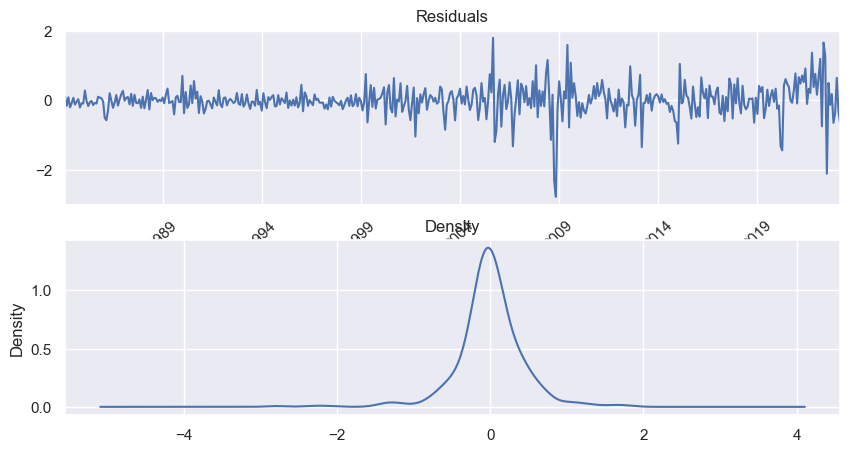

In [116]:
residuals = arima_fit.resid[1:]
fig, ax = plt.subplots(2,1, figsize = (10,5))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

plt.show()

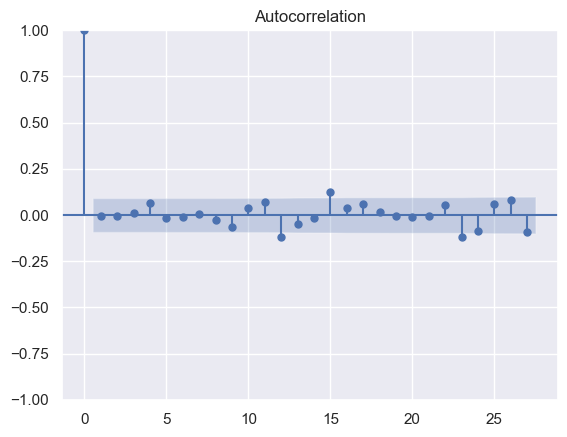

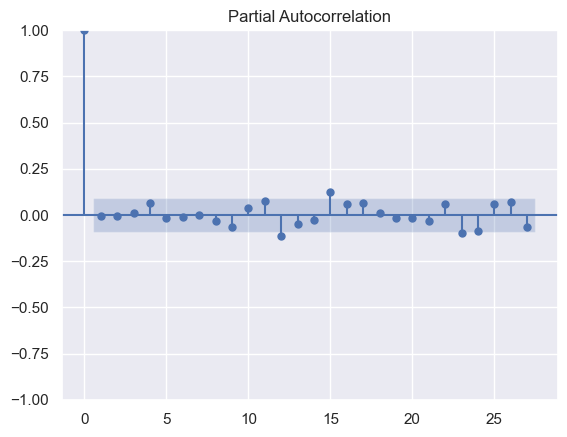

In [36]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

# Forecasting


In [37]:
arima_model = ARIMA(detrend['CPI-rolMean'], order = (1,0,2),freq=test.index.inferred_freq)
arima_fit = arima_model.fit()
ARIMA_forecast = arima_fit.forecast(steps=12) # We forecast for 12 months. 

print('The Core CPI value for the month April 2023 predicted by ARIMA model is', round(ARIMA_forecast[0]+rmean[-1],2))
print(' This number is the summation of the rolling mean and the forecast from ARIMA which will give us the real prediction')

The Core CPI value for the month April 2023 predicted by ARIMA model is 301.2
 This number is the summation of the rolling mean and the forecast from ARIMA which will give us the real prediction


### Forecasting for 12 months

In [38]:
def forecster (df, preds):    
    total_pred = df['CPI'] #creating structure for the future ARIMA forecast
    rmean=total_pred.rolling(window=12).mean()


    for p in preds: #each value for the forecast is the addition of the ARIMA predictions witht he rolling mean of the previous month. The new rolling mean is recalculated every time. 
        monthly_pred_row = {'CPI':p+rmean[len(rmean)-1]}
        total_pred = total_pred.append(pd.Series(monthly_pred_row), ignore_index=True)
        rmean=total_pred.rolling(window=12).mean()

    total_pred.index= df.index.append(ARIMA_forecast.index)
    total_pred = pd.Series(total_pred)
    return total_pred

In [39]:
total_pred_ARIMA = forecster(df, ARIMA_forecast)

# GARCH

### generalized autoregressive conditional heteroskedasticity.
Heteroskedasticity describes the irregular pattern of variation of an error term, or variable, in a statistical model. Essentially, where there is heteroskedasticity, observations do not conform to a linear pattern. Instead, they tend to cluster.

The result is that the conclusions and predictive value drawn from the model will not be reliable. GARCH is a statistical model that can be used to analyze a number of different types of financial data, for instance, macroeconomic data. Financial institutions typically use this model to estimate the volatility of returns for stocks, bonds, and market indices. They use the resulting information to determine pricing, judge which assets will potentially provide higher returns, and forecast the returns of current investments to help in their asset allocation, hedging, risk management, and portfolio optimization decisions.

The general process for a GARCH model involves three steps. The first is to estimate a best-fitting autoregressive model. The second is to compute autocorrelations of the error term. The third step is to test for significance.

Two other widely used approaches to estimating and predicting financial volatility are the classic historical volatility (VolSD) method and the exponentially weighted moving average volatility (VolEWMA) method.

In [40]:
# a standard GARCH(1,1) model
garch = arch_model(detrend['CPI-rolMean'], vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 647202163432.4307
Iteration:      2,   Func. Count:     15,   Neg. LLF: 326887514.90832186
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3753.2671847983065
Iteration:      4,   Func. Count:     27,   Neg. LLF: 23538.46500388936
Iteration:      5,   Func. Count:     33,   Neg. LLF: 609.3456243383474
Iteration:      6,   Func. Count:     39,   Neg. LLF: 581.3233722371423
Iteration:      7,   Func. Count:     45,   Neg. LLF: 734.8673119956575
Iteration:      8,   Func. Count:     51,   Neg. LLF: 714.3345666090729
Iteration:      9,   Func. Count:     57,   Neg. LLF: 679.239727959221
Iteration:     10,   Func. Count:     63,   Neg. LLF: 640.2427701133998
Iteration:     11,   Func. Count:     69,   Neg. LLF: 619.5913832122005
Iteration:     12,   Func. Count:     75,   Neg. LLF: 520.6014682477769
Iteration:     13,   Func. Count:     80,   Neg. LLF: 581.6051034735918
Iteration:     14,   Func. Count:     86,   Neg. LLF: 1825.3360

In [41]:
garch_fitted.summary

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:            CPI-rolMean   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -516.881
Distribution:                  Normal   AIC:                           1041.76
Method:            Maximum Likelihood   BIC:                           1058.38
                                        No. Observations:                  471
Date:                Tue, May 09 2023   Df Residuals:                      470
Time:                        09:43:40   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.9864  3.636e

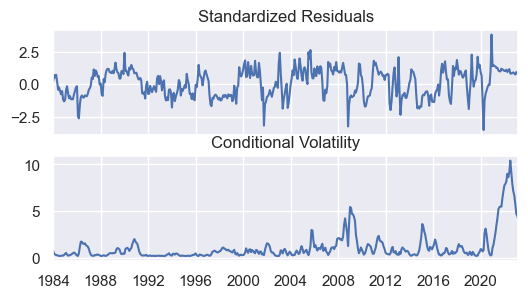

In [115]:


fig = garch_fitted.plot().set_size_inches(6, 3) # Bug in program, have to assign to a to avoid duplicate plotting


In [105]:
garch_fitted

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            CPI-rolMean   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -516.881
Distribution:                  Normal   AIC:                           1041.76
Method:            Maximum Likelihood   BIC:                           1058.38
                                        No. Observations:                  471
Date:                Tue, May 09 2023   Df Residuals:                      470
Time:                        09:43:40   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.9864  3.636e-02     54.637      0.000 [  1.915,  2.05

In [43]:
# one-step out-of sample forecast
GARCH_forecast = garch_fitted.forecast(horizon=12).variance[-1:].T # Checked the comments on the original source, have to use variance here as opposed to the mean. 
GARCH_forecast =  pd.Series(list(GARCH_forecast['2023-03-01']), index = ARIMA_forecast.index)
total_pred_GARCH = forecster(df, GARCH_forecast)
type(total_pred_GARCH)
total_pred_GARCH.tail(12)

2023-04-01    308.115772
2023-05-01    309.771396
2023-06-01    311.343572
2023-07-01    312.758430
2023-08-01    314.299526
2023-09-01    315.911380
2023-10-01    317.555971
2023-11-01    319.216946
2023-12-01    320.965418
2024-01-01    322.826929
2024-02-01    324.714733
2024-03-01    326.667188
dtype: float64

<Axes: xlabel='date'>

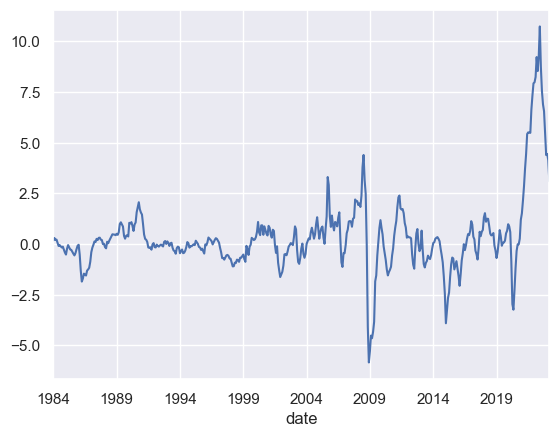

In [44]:
garch_fitted.resid.plot()

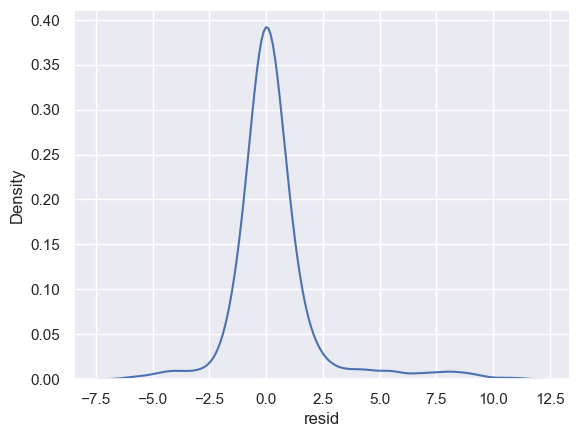

In [45]:
#garch_fitted.resid.hist(bins=50)
res = sns.kdeplot(garch_fitted.resid)

## Plotting ARIMA and GARCH Forecasts

In [46]:
# Plotting the predictions

fig = go.Figure()
fig.add_trace(go.Scatter(x = df[df.index>'01-12-2019'].index, y = df[df.index>'01-12-2019']['CPI'], mode = 'lines', name = 'CPI'))
fig.add_trace(go.Scatter(x = total_pred_ARIMA.tail(12).index, y = total_pred_ARIMA.tail(12), mode = 'markers', name = 'ARIMA forecast'))
fig.add_trace(go.Scatter(x = total_pred_GARCH.tail(12).index, y = total_pred_GARCH.tail(12), mode = 'markers', name = 'GARCH forecast'))



fig.update_layout(title=dict(text = 'Current CPI trend and the forecast for  the next 12 months',
                              font = dict(size = 22)),autosize=False,
    width=1000,
    height=300,
    )
fig.show()

# Prophet


In [47]:
df_p

NameError: name 'df_p' is not defined

In [ ]:
df_p

,y
date,
1980-01-01,78.000
1980-02-01,79.000
1980-03-01,80.100
1980-04-01,80.900
1980-05-01,81.700
...,...
2022-11-01,298.598
2022-12-01,298.990
2023-01-01,300.536


In [ ]:
df

,CPI
date,
1980-01-01,78.000
1980-02-01,79.000
1980-03-01,80.100
1980-04-01,80.900
1980-05-01,81.700
...,...
2022-11-01,298.598
2022-12-01,298.990
2023-01-01,300.536


In [ ]:
df = parse_json(all_json_data)
df = df[df.index>'01-01-2000']
df.reset_index(inplace=True)
df_p = df.copy()
df_p.rename(columns={'date':'ds','CPI':'y'}, inplace=True)
df_p['ds'] = df_p['ds'].astype(str)
#del df2['pct-change']

In [ ]:
m = Prophet()
m.fit(df_p)
future = m.make_future_dataframe(periods = 365)
future

17:28:04 - cmdstanpy - INFO - Chain [1] start processing
17:28:04 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2000-02-01
1,2000-03-01
2,2000-04-01
3,2000-05-01
4,2000-06-01
...,...
638,2024-02-25
639,2024-02-26
640,2024-02-27
641,2024-02-28


In [ ]:

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
638,2024-02-25,309.260617,305.111110,312.762227
639,2024-02-26,308.183901,304.135727,312.078597
640,2024-02-27,307.130761,303.133423,310.996085
641,2024-02-28,306.120161,302.290935,310.137632
642,2024-02-29,305.169209,301.086693,308.704704


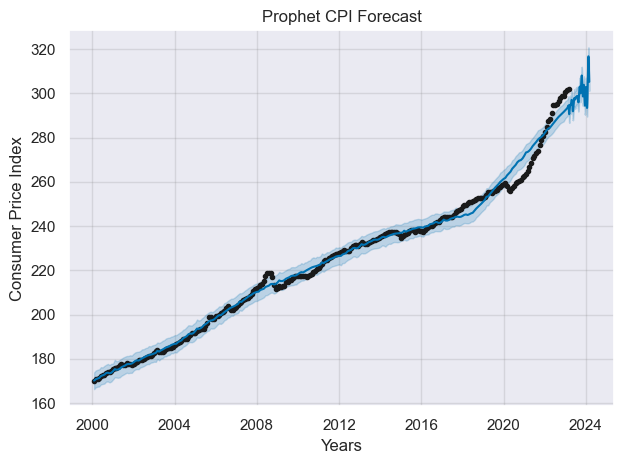

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Prophet CPI Forecast")
fig1 = m.plot(forecast, xlabel ='Years', ylabel="Consumer Price Index",ax = ax)


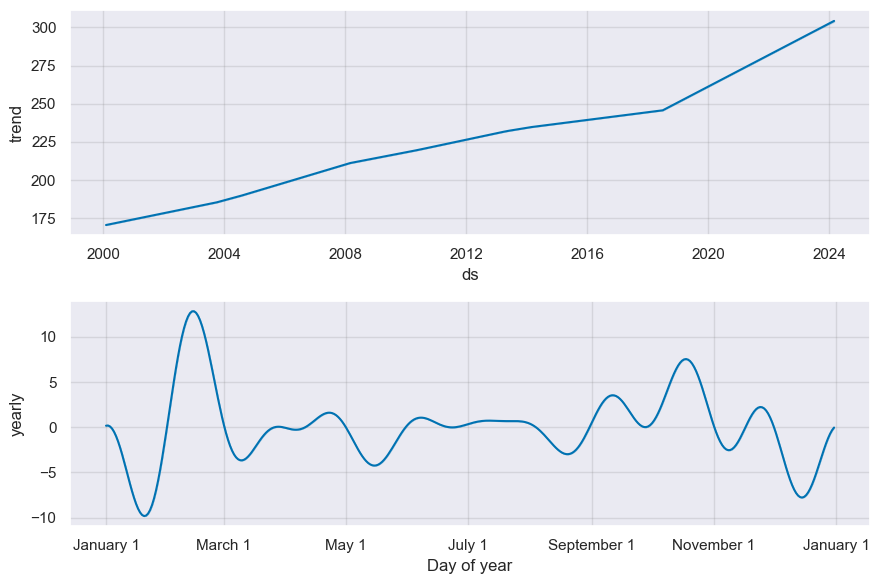

In [ ]:

fig = m.plot_components(forecast)



In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)
plot

In [ ]:
plot_components_plotly(m, forecast)
plot_

In [ ]:
from scipy.optimize import curve_fit

